In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import pywt

import sys
import copy

sys.path.insert(0,'/Users/orentapiero/btc_research/')

from btc_functions.glassnode import *
from btc_functions.import_data import get_glassnode_price,get_glassnode_data
from btc_functions.variable_list_urls import *
from btc_functions.utilities import strided_app,strided_app2

plt.rcParams['figure.figsize'] = [15, 10]
sns.set()

In [2]:
def WT(index_list, wavefunc='db4', lv=4, m=4, n=4, plot=False):
    
    '''
    WT: Wavelet Transformation Function
    index_list: Input Sequence;
   
    lv: Decomposing Level；
 
    wavefunc: Function of Wavelet, 'db4' default；
    
    m, n: Level of Threshold Processing
   
    '''
   
    # Decomposing 
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   #  Decomposing by levels，cD is the details coefficient
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn function 

    # Denoising
    # Soft Threshold Processing Method
    for i in range(m,n+1):   #  Select m~n Levels of the wavelet coefficients，and no need to dispose the cA coefficients(approximation coefficients)
        cD = coeff[i]
        Tr = np.sqrt(2*np.log2(len(cD)))  # Compute Threshold
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) -  Tr)  # Shrink to zero
            else:
                coeff[i][j] = 0   # Set to zero if smaller than threshold

    # Reconstructing
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])
    
    for i in range(len(coeff)):
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)
        if len(coeff[i]) > len(index_list):
            coeff[i] = coeff[i][:-1]
        
    if plot:     
        denoised_index = np.sum(coeff, axis=0)   
        data = pd.DataFrame({'CLOSE': index_list, 'denoised': denoised_index})
        data.plot(figsize=(10,10),subplots=(2,1))
        data.plot(figsize=(10,5))
   
    return coeff

In [3]:
class WaveletIndicators(object):
    def __init__(self,wavefunc='db3',lv=4,m=4,n=4,verbose=True):
        self.wavefunc = wavefunc
        self.lv = lv
        self.m = m
        self.n = n
        self.verbose = verbose
    
    def _dwtfilt(self,y):
        self.coeff = WT(y,wavefunc=self.wavefunc,lv=self.lv,m=self.m,n=self.n,plot=False)
    
    def _component(self,y,n_comp=3):
        coeff = self.coeff
        x = coeff[0]
        
        if n_comp > 0:
            x = coeff[0]
            for j in range(1,n_comp+1):
                x += coeff[j]
        return x
        
    def _end_point(self,y,n_comp=3):
        self._dwtfilt(y)
        x = self._component(y,n_comp=n_comp)            
        return x[-1]
    
    def _end_velocity(self,y,n_comp=3,ndiff=1):
        self._dwtfilt(y)
        x = self._component(y,n_comp)                    
        dx = 10000*(np.log(x[-1])-np.log(x[-(ndiff+1)]))
        return dx
    
    def _end_acceleration(self,y,n_comp=3,ndiff=1):
        self._dwtfilt(y)
        x = self._component(y,n_comp)                    
        ddx = 10000*(np.log(x[-1])-2*np.log(x[-(ndiff+1)])+np.log(x[-2*(ndiff+1)]))
        return ddx
    
    def _avg_bps(self,y,n_comp=3,nmean=12):
        self._dwtfilt(y)
        x = self._component(y,n_comp) 
        dx = 10000*np.diff(np.log(x))
        return np.mean(dx[-nmean:])

    def _avg_abs_bps(self,y,n_comp=3,nmean=12):
        self._dwtfilt(y)
        x = self._component(y,n_comp) 
        dx = np.abs(10000*np.diff(np.log(x)))
        return np.mean(dx[-nmean:])

    def _med_bps(self,y,n_comp=3,nmean=12):
        self._dwtfilt(y)
        x = self._component(y,n_comp) 
        dx = 10000*np.diff(np.log(x))
        return np.median(dx[-nmean:])

    def rolling_end_point(self,Series,nbars,n_comp=3):
        idx = Series.index
        stp = strided_app(Series.values,nbars,1)
        y = np.empty_like(price.values)
        y[:] = np.nan
        
        if self.verbose==True:
            iteration = tqdm(range(stp.shape[0]))
        else:
            iteration = tqdm(range(stp.shape[0]))
        
        y[(nbars-1):]=[self._end_point(stp[j,:],n_comp) for j in iteration]
        return pd.Series(y,index = idx)

    def rolling_end_velocity(self,Series,nbars,n_comp=3,ndiff = 1):
        idx = Series.index
        stp = strided_app(Series.values,nbars,1)
        y = np.empty_like(price.values)
        y[:] = np.nan
        
        if self.verbose==True:
            iteration = tqdm(range(stp.shape[0]))
        else:
            iteration = (range(stp.shape[0]))
        
        y[(nbars-1):]=[self._end_velocity(stp[j,:],n_comp,ndiff) for j in iteration]
        return pd.Series(y,index = idx)
    
    def rolling_end_acceleration(self,Series,nbars,n_comp=3,ndiff = 1):
        idx = Series.index
        stp = strided_app(Series.values,nbars,1)
        y = np.empty_like(price.values)
        y[:] = np.nan
        
        if self.verbose==True:
            iteration = tqdm(range(stp.shape[0]))
        else:
            iteration = range(stp.shape[0])
        
        y[(nbars-1):]=[self._end_acceleration(stp[j,:],n_comp,ndiff) for j in iteration]
        return pd.Series(y,index = idx)

    def rolling_avg_bps(self,Series,nbars,n_comp=3,nmean = 12):
        idx = Series.index
        stp = strided_app(Series.values,nbars,1)
        y = np.empty_like(price.values)
        y[:] = np.nan
        
        if self.verbose==True:
            iteration = tqdm(range(stp.shape[0]))
        else:
            iteration = range(stp.shape[0])
        
        y[(nbars-1):]=[self._avg_bps(stp[j,:],n_comp,nmean) for j in iteration]
        return pd.Series(y,index = idx)
    
    def rolling_med_bps(self,Series,nbars,n_comp=3,nmean = 12):
        idx = Series.index
        stp = strided_app(Series.values,nbars,1)
        y = np.empty_like(price.values)
        y[:] = np.nan
        
        if self.verbose==True:
            iteration = tqdm(range(stp.shape[0]))
        else:
            iteration = range(stp.shape[0])
        
        y[(nbars-1):]=[self._med_bps(stp[j,:],n_comp,nmean) for j in iteration]
        return pd.Series(y,index = idx)
    
    def rolling_abs_bps(self,Series,nbars,n_comp=3,nmean = 12):
        idx = Series.index
        stp = strided_app(Series.values,nbars,1)
        y = np.empty_like(price.values)
        y[:] = np.nan
        
        if self.verbose==True:
            iteration = tqdm(range(stp.shape[0]))
        else:
            iteration = range(stp.shape[0])
        
        y[(nbars-1):]=[self._avg_abs_bps(stp[j,:],n_comp,nmean) for j in iteration]
        return pd.Series(y,index = idx)

In [4]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def numpy_avg_bps(r,L):
    avg_bps = np.empty_like(r)
    avg_bps[:] = np.nan
    
    if np.isnan(r[0]):
        avg_bps_ = moving_average(r[1:],L)
        avg_bps[L:] = avg_bps_.tolist()
    else:
        avg_bps_ = moving_average(r,L)
        avg_bps[(L-1):] = avg_bps_.tolist()
    return avg_bps
    
def lag(x,L=1):
    Lx = np.empty_like(x)
    Lx[:] = np.nan
    Lx[L:] = x[:-L]
    return Lx

In [5]:
ohlc = get_glassnode_price()
ohlc = ohlc.rename(columns = {'o':'Open','h':'High','l':'Low','c':'Close'})
ohlc['px'] = ohlc[['High','Low']].mean(1)

In [6]:
features = get_glassnode_data(Indicators+['deltacap_usd'],Urls)

  0%|          | 0/82 [00:00<?, ?it/s]

cannot get hash_ribbon.
cannot get difficulty_ribbon.
403 Client Error: Forbidden for url: https://api.glassnode.com/v1/metrics/indicators/nvt_entity_adjusted?a=BTC&i=24h&c=native&api_key=1vUcyF35hTk9awbNGszF0KcLuYH
this asset is forbidden for endpoint

Expecting value: line 1 column 1 (char 0)
cannot get nvt_entity_adjusted.
403 Client Error: Forbidden for url: https://api.glassnode.com/v1/metrics/indicators/spent_output_price_distribution_ath?a=BTC&i=24h&c=native&api_key=1vUcyF35hTk9awbNGszF0KcLuYH
this asset is forbidden for endpoint

Expecting value: line 1 column 1 (char 0)
cannot get spent_output_price_distribution_ath.
403 Client Error: Forbidden for url: https://api.glassnode.com/v1/metrics/indicators/spent_output_price_distribution_percent?a=BTC&i=24h&c=native&api_key=1vUcyF35hTk9awbNGszF0KcLuYH
this asset is forbidden for endpoint

Expecting value: line 1 column 1 (char 0)
cannot get spent_output_price_distribution_percent.
403 Client Error: Forbidden for url: https://api.gla

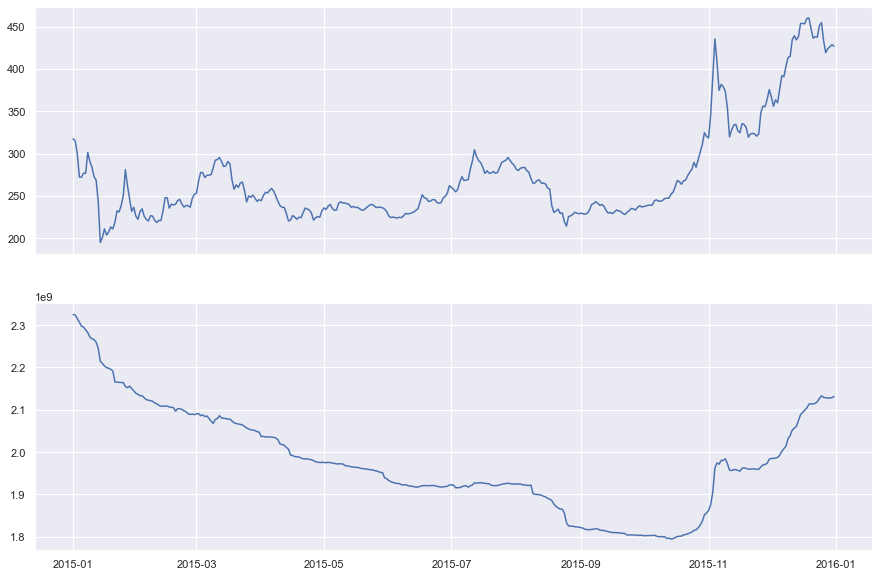

In [7]:
year = '2015'
f,a = plt.subplots(nrows = 2,sharex = True)
a[0].plot(ohlc.loc[year,'px'])
a[1].plot(features.loc[year,'deltacap_usd'])

In [8]:
WI = WaveletIndicators(wavefunc='db5')
WI._dwtfilt(ohlc.px.loc[year])

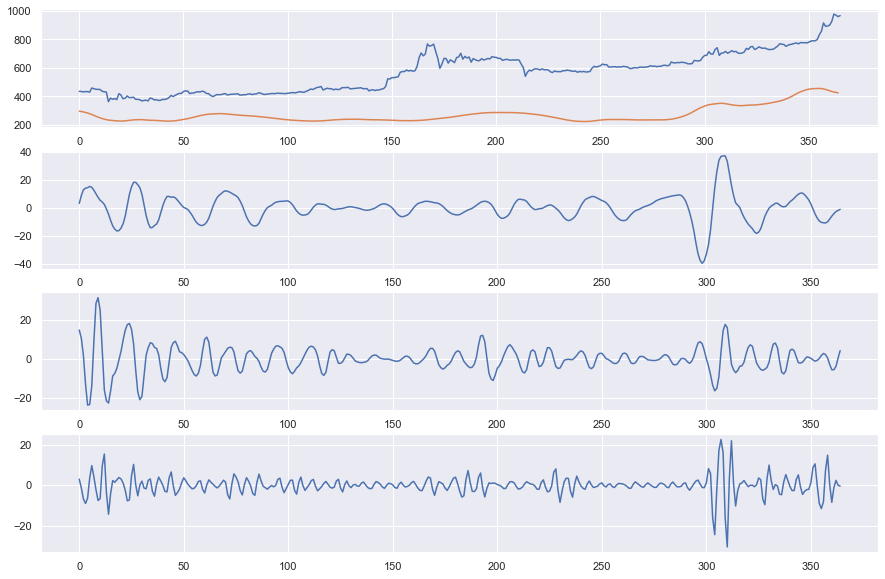

In [9]:
f,a=plt.subplots(nrows=4)
a[0].plot(ohlc.Close.loc['2016'].values)
a[0].plot(WI.coeff[0])
a[1].plot(WI.coeff[1])
a[2].plot(WI.coeff[2])
a[3].plot(WI.coeff[3])

In [10]:
from statsmodels.tsa.stattools import adfuller

r0 = np.diff(np.log(WI.coeff[0]),prepend=np.nan)
adfuller(np.diff(np.log(WI.coeff[0]),prepend=np.nan)[1:])


(-3.527638431537602,
 0.0073050123498200285,
 17,
 346,
 {'1%': -3.4493918438232525,
  '5%': -2.8699298018856574,
  '10%': -2.5712397066390458},
 -4462.358405365989)

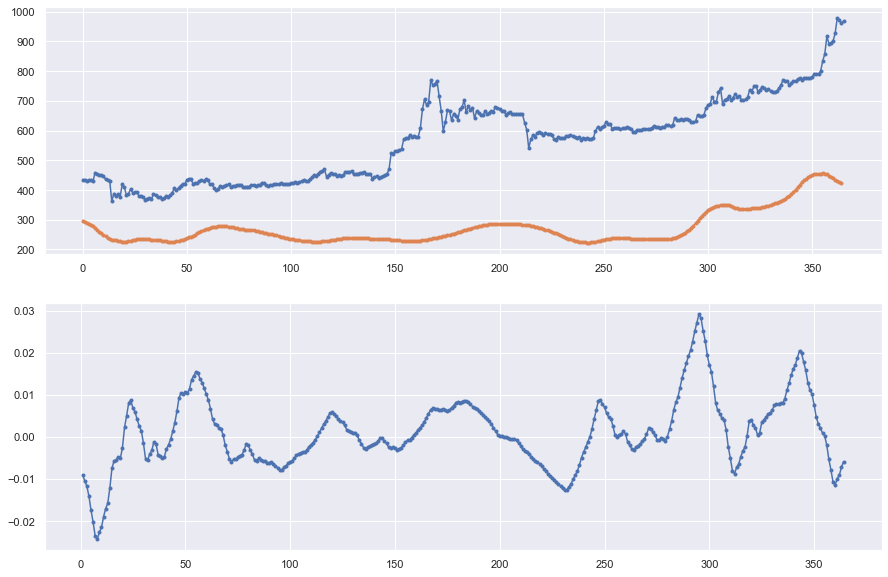

In [11]:
f,a=plt.subplots(nrows=2)
a[0].plot(ohlc.Close.loc['2016'].values,'.-')
a[0].plot(WI.coeff[0],'.-')
a[1].plot(r0,'.-')